This is a notebook to recap all the code used in my texxt mining final project.

# 1 Dataset creation

Need to create a dataset of competitive programming task. The dataset should include: problem_id, problem name problem description, difficulty, sample input, sample output. 

Needed: A method of extracting kattis problem informations , filtering out the sample in/out in problem description, also download .input and .ouput files.

## Fetching competitive programming problems from the open.kattis.com 

I use the python library autokattis to extract competitive programming problems from the open.kattis.com website. This website is the support for all the ICPC programming contests. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
from dotenv import load_dotenv
from autokattis import OpenKattis
from submit import *
from utils import *
import ast
import sys
import io
import contextlib
from io import StringIO
import builtins
from typing import Tuple, Optional, Union
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


Task started...
Task completed.
None


In [2]:
load_dotenv()
user = os.getenv("USER")
password = os.getenv("PASSWORD")
print(os.getenv("TEST"))

kt = OpenKattis(user, password)

.env imported successfully
https://open.kattis.com/
[login] Candidate username(s): ['hugo-morvan']
[login] Successfully logged in to Kattis as hugo-morvan!
[database] Listed all available languages!
[database] Listed all 208 available countries!
[database] Listed all 3940 available universities!


Here is a plot showing the distribution of problem difficulty on Kattis.

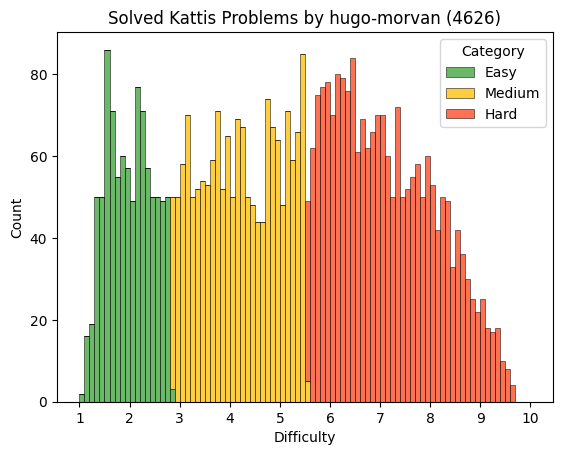

In [3]:
kt.plot_problems(show_partial=True, show_solved=True, show_tried=True, show_untried=True)

In [4]:
#Fetching all solved the problems available on the website.
problems = kt.problems(low_detail_mode=False, show_tried=True, show_untried=True) 
print(type(problems))
print(len(problems))

<class 'autokattis.api.ABCKattis.Result'>
4626


In [10]:
df = pd.DataFrame(problems)
df.head(5)

,name,id,fastest,shortest,total,acc,difficulty,category,link
0,10 Kinds of People,10kindsofpeople,0.01,368,40086,7685,4.6,Medium,https://open.kattis.com/problems/10kindsofpeople
1,1-D Frogger (Easy),1dfroggereasy,0.00,150,10618,2073,3.2,Medium,https://open.kattis.com/problems/1dfroggereasy
2,1-D Frogger (Hard),1dfroggerhard,0.03,472,5532,482,8.2,Hard,https://open.kattis.com/problems/1dfroggerhard
3,1's For All,1sforall,0.00,5,3318,625,6.3,Hard,https://open.kattis.com/problems/1sforall
4,2048,2048,0.00,5,17519,7139,3.0,Medium,https://open.kattis.com/problems/2048


### Selection of problems for evaluation

Because trying to solve all the problems available is not feasible, we select a representative sample of problems to test the different LLM on. Ideally, the selected problems should match the distribution of problem difficulty of the whole dataset.

In [11]:
sampled_df = df.sample(n=100, random_state=1)

In [8]:
sampled_df = combined_df

<Figure size 1500x1000 with 0 Axes>

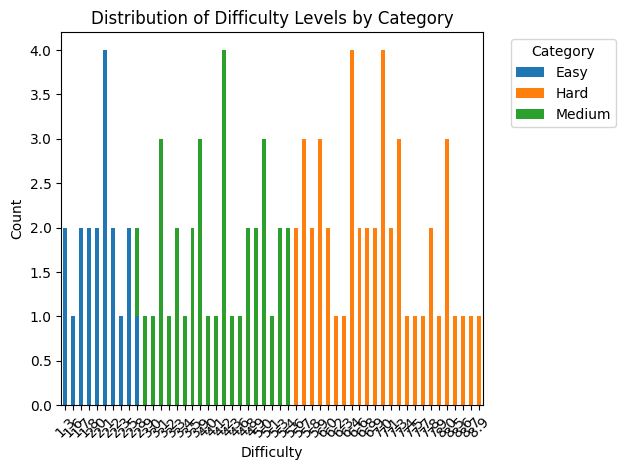

In [12]:
color_map = {'Easy': 'green','Medium': 'yellow','Hard': 'red'}
plt.figure(figsize=(15, 10))
sampled_df.groupby(['difficulty', 'category']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Difficulty Levels by Category')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The plot shows a good spread in the problem difficulty selected, however the sample size is too small to have a true representative distribution. We can now use the problem IDs to extract the problems descriptions from the same API using another function of the autokattis package.

In [22]:
# Extract problem IDs from the sampled DataFrame
problem_ids = sampled_df['id'].tolist()

# Fetch problem details using kt.problem()
problem_details = kt.problem(problem_ids)

# Extract specific details you're interested in
problem_details_extracted = []
for problem in problem_details:
    problem_details_extracted.append({
        'id': problem['id'],
        'text': problem['text'],
        'difficulty': problem.get('difficulty'),
        'category': problem.get('category'),
        'cpu_time': problem.get('cpu'),
        'memory_limit': problem.get('memory'),
        'sample_input': problem['files'].get('sample.in', '') if 'files' in problem else '',
        'sample_output': problem['files'].get('sample.ans', '') if 'files' in problem else ''
    })

# Convert to DataFrame
problem_info_df = pd.DataFrame(problem_details_extracted)

# Merge with original sampled DataFrame
combined_df = sampled_df.merge(problem_info_df, on='id')

**Checkpoint**: saving the data to csv then reloading it. avoids running all the above when reloading the notebook.

In [6]:
combined_df.to_csv('data.csv', index=False)

NameError: name 'combined_df' is not defined

In [7]:
combined_df = pd.read_csv('data.csv')
#combined_df.head(5)

Some data cleaning is needed to extract problem descriptions,  expected input format, expected output format, and sample test cases. Here is a function to do just that:

In [4]:
# Testing the parse_desc function:
problem_id = 2
print(f"problem id: {combined_df['id'][problem_id]}")
#print(f"raw-desc: \n{combined_df['text'][problem_id]}")
description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem_id])
print(f"{description=}")
print(f"{input_rec=}")
print(f"{output_rec=}")
print(f"{test_cases_tuples=}")

problem id: snappereasy
description='Note that this is an easier version of the problem snapperhard The Snapper is a clever little device that, on one side, plugs its input plug into an output socket, and, on the other side, exposes an output socket for plugging in a light or other device. When a Snapper is in the ON state and is receiving power from its input plug, then the device connected to its output socket is receiving power as well. When you snap your fingers – making a clicking sound – any Snapper receiving power at the time of the snap toggles between the ON and OFF states. In hopes of destroying the universe by means of a singularity, I have purchased $N$ Snapper devices and chained them together by plugging the first one into a power socket, the second one into the first one, and so on. The light is plugged into the $N$th Snapper. Initially, all the Snappers are in the OFF state, so only the first one is receiving power from the socket, and the light is off. I snap my finger

# 2 Model evaluation

Need to create a custom evaluation for the model based on different levels of quality of the code produce by the LLM.
- Level 1: The code is written in the desired language (python) and compile without error.
- Level 2: The code can run on the test input/output without errors
- Level 3: The code succesfully solves the problem on the given sample input/output
- Level 4: The code can run on the hidden input/output withour errors
- Level 5: The code succesfully solves the hidden test cases.

Idea for evaluation: attribute points based on how many level a code generated passes. aggregate the results and rank the LLM accordingly.
To save on calculation, only evaluate level N if N-1 is validated (i.e don't bombard Kattis with non-working code. test Locally prior to testing online)

Needed : 
- A systematic method of evaluating each level. Already exists for level 5.
-> exec("code generated with {input}"), assert result = {output}


### Level 1 check: Does the code compile ?

In case of error, the type of error should be saved for statistics purposes.

In [3]:
import ast
import io
import contextlib
import importlib.util

# Helper function to check if a module is part of the standard library
def is_standard_library(module_name):
    try:
        spec = importlib.util.find_spec(module_name)
        if spec and spec.origin and "site-packages" not in spec.origin:
            return True
    except ModuleNotFoundError:
        return False
    return False

def check_code_compilation(code_string):
    try:
        tree = ast.parse(code_string)
        undefined_vars = set()
        defined_vars = set()
        
        builtin_dict = __builtins__ if isinstance(__builtins__, dict) else __builtins__.__dict__

        class VarValidator(ast.NodeVisitor):
            def visit_FunctionDef(self, node):
                # Add the function name to defined variables
                defined_vars.add(node.name)
                # Add function arguments to defined variables
                for arg in node.args.args:
                    defined_vars.add(arg.arg)
                self.generic_visit(node)
                
            def visit_Lambda(self, node):
                # Handle lambda expressions
                lambda_args = {arg.arg for arg in node.args.args}
                defined_vars.update(lambda_args)  # Add lambda arguments to defined_vars
                self.generic_visit(node)

            def visit_Name(self, node):
                # Handle variable assignment and usage
                if isinstance(node.ctx, ast.Store):
                    defined_vars.add(node.id)
                elif isinstance(node.ctx, ast.Load):
                    if (node.id not in defined_vars and 
                        node.id not in builtin_dict):
                        undefined_vars.add(node.id)
                self.generic_visit(node)

            def visit_comprehension(self, node):
                # Handle comprehensions (e.g., for i in ...)
                if isinstance(node.target, ast.Name):
                    defined_vars.add(node.target.id)
                self.generic_visit(node)

            def visit_Import(self, node):
                # Handle import statements
                for alias in node.names:
                    if not is_standard_library(alias.name):
                        raise ImportError(f"Importing non-standard library '{alias.name}' is not allowed.")
                    defined_vars.add(alias.asname if alias.asname else alias.name)

            def visit_ImportFrom(self, node):
                # Handle from-import statements
                if node.module and not is_standard_library(node.module):
                    raise ImportError(f"Importing from non-standard library '{node.module}' is not allowed.")
                for alias in node.names:
                    defined_vars.add(alias.asname if alias.asname else alias.name)

            def visit_ListComp(self, node):
                # Handle list comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_DictComp(self, node):
                # Handle dictionary comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_SetComp(self, node):
                # Handle set comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_GeneratorExp(self, node):
                # Handle generator expressions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

        # Visit the AST tree for variable validation and import checking
        VarValidator().visit(tree)

        if undefined_vars:
            return False, f"Undefined variables: {', '.join(undefined_vars)}"
            
        error_output = io.StringIO()
        with contextlib.redirect_stderr(error_output):
            compile(code_string, '<string>', 'exec')
        
        return True, ""
        
    except ImportError as e:
        return False, str(e)
    except SyntaxError as e:
        error_msg = (
            f"Syntax Error: {e.msg}\n"
            f"Line {e.lineno}, Column {e.offset}\n"
            f"Text: {e.text.strip() if e.text else 'N/A'}"
        )
        return False, error_msg
    except Exception as e:
        return False, str(e)


In [ ]:
# Example usage
def test_code_compilation():
    # Test cases
    test_cases = [
        # Compilable code
        """
def hello_world():
    hello = "test"
    print(hello)
    print("Hello, World!")

hello_world()
""",
        # Code with syntax error
        """
def hello_world()
    print("Hello, World!")
""",
        # Code with indentation error
        """
def hello_world():
print("Hello, World!")
""",
        # Code with imported function 
        """
from math import sqrt

N = 5
result = sqrt(4)
""",
        # Code with list comprehension
        """
N = 5
squared = [x**2 for x in range(N)]
""",
        # Code with lambda expression
        """
N = 5
squared = lambda x: x**2
print(squared(4))
""",
        # Code with undefined variable
        """
result = sqrt(my_var)
""",
        # Code with non-standard library import
        """
import numpy as np
"""
    ]
    
    for code in test_cases:
        is_compilable, error_message = check_code_compilation(code)
        print(f"Code:\n{code}")
        print(f"Compilable: {is_compilable}")
        if not is_compilable:
            print(f"Error: {error_message}")
        print("-" * 40)

# Uncomment to run tests
test_code_compilation()

### Level 2 and 3 and check: does the code run on test cases ?

If yes, give some points. Half of problem difficulty ?
In case of error, the type of error should be saved for statistics purposes.

In [4]:
def test_code_output(code_str, input_str, expected_output):
    """
    Tests if running the provided code with given input produces the expected output.
    
    Args:
        code_str (str): The Python code to test as a string
        input_str (str): The input to provide to the code
        expected_output (str): The expected output to compare against
    
    Returns:
        Tuple[bool, Optional[Union[str, Exception]]]: 
            - First element is True if execution was successful and output matches, False otherwise
            - Second element contains:
                - None if everything is correct
                - Exception object if there was an execution error
                - String with actual output if output doesn't match expected output
    
    Example:
        code = '''
        n = int(input())
        print(n * 2)
        '''
        success, error = test_code_output(code, "5", "10")  # Returns (True, None)
    """
    # Create StringIO object for output
    output_buffer = StringIO()
    
    # Store the original stdout and input function
    original_stdout = sys.stdout
    original_input = builtins.input
    
    # Create an iterator of input lines
    input_lines = iter(input_str.splitlines())
    
    # Define mock input function
    def mock_input(*args):
        try:
            return next(input_lines)
        except StopIteration:
            raise EOFError("No more input available")
    
    try:
        # Redirect stdout and override input
        sys.stdout = output_buffer
        builtins.input = mock_input
        
        # Execute the code in a separate namespace
        namespace = {'__name__': '__main__'}
        exec(code_str, namespace)
        
        # Get the actual output and strip whitespace
        actual_output = output_buffer.getvalue().strip()
        expected_output = expected_output.strip()
        
        # Compare actual output with expected output
        if actual_output == expected_output:
            return True, None
        else:
            return False, f"WrongOutput(Expected: '{expected_output}'\nGot: '{actual_output}')"
        
    except Exception as e:
        return False, e
        
    finally:
        # Restore original stdout and input function
        sys.stdout = original_stdout
        builtins.input = original_input
        output_buffer.close()

In [ ]:
# Example 1: Testing a simple doubling program
code = """
n = int(input())
print(n * 2)
"""
result = test_code_output(code, "5", "10")
print(result)  # True

# Example 2: Testing a program with incorrect output
result = test_code_output(code, "5", "11")
print(result)  # False

# Example 3: Testing a program with multiple inputs
code_multiple = """
a = input()
b = input(
print(a + b)
"""
result = test_code_output(code_multiple, "hello\nworld", "helloworld")
print(result)  # True

### Level 4 and 5 and check: does the code run on test cases ?

Here we need to submit the code to the kattis website to know if the code produced passes the hidden test cases.
The Kattis CLI tool is used to do that. Only the codes that passes the level 3 should be submitted to the katti website. In case of error, the type of error should be saved for statistics purposes.

In [ ]:


#Write solution to a python file
write_solution(file_path, code)
#submit the solution to the kattis website
submit_problem(file_path , pid)

# 3 LLM Prompting

Need to create a prompt that give the description as well as sample input output to the LLM. 
Can try different methods:
- description only
- description + sample input/output
- language LLM
- Code specific LLM
- Language to Code LLM pipeline
- Different quantization methods, 
- Different model sizes.


## Generate all the code solutions

In [5]:
# Qwen generator
class QwenGenerator:
    def __init__(
        self,
        model_name: str = "Qwen/Qwen2.5-Coder-7B-Instruct",
        use_half_precision: bool = True
    ):
        # Initialize device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Generator running on device :{self.device}")
        # Load model with optimizations
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if use_half_precision and self.device == "cuda" else "auto",
            device_map="auto"
        )
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Enable evaluation mode
        self.model.eval()
        
        # Cache for template
        self._system_message = {
            "role": "system", 
            "content": """
            You are a highly skilled competitive python programmer. 
            When given a prompt, you only output code. 
            Your code should take in inputs using the input() function and return outputs using print().
            """
        }
        
        # Initialize CUDA graph variables if using GPU
        self.static_input_shape = None
        self.static_graph = None

    def generate_solution(self, description: str, max_new_tokens: int = 512) -> str:
        # Prepare messages
        messages = [
            self._system_message,
            {"role": "user", "content": description}
        ]
        
        # Apply template
        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False, # Note to self: Can modify this line to test effect of description tokenization
            add_generation_prompt=True
        )
        
        # Tokenize with optimization for GPU
        with torch.inference_mode():
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.device)
            
            # Use CUDA graphs for repeated operations with same input size
            if (self.device == "cuda" and 
                (self.static_input_shape is None or 
                 self.static_input_shape != model_inputs.input_ids.shape)):
                
                self.static_input_shape = model_inputs.input_ids.shape
                torch.cuda.empty_cache()
                
                # Generate with optimized settings
                generated_ids = self._generate_optimized(model_inputs, max_new_tokens)
            else:
                generated_ids = self._generate_optimized(model_inputs, max_new_tokens)
        
        # Post-process generated IDs
        generated_ids = [
            output_ids[len(input_ids):] 
            for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        
        # Decode and clean up response
        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return response  
    
    def _generate_optimized(self, model_inputs, max_new_tokens: int):
        '''
        If you need to adjust generation speed vs quality:

        Lower temperature (e.g., 0.5) for more focused output
        Lower max_new_tokens if you don't need long responses
        Adjust top_p (e.g., 0.8) for more deterministic output  
        '''
        return self.model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=self.tokenizer.pad_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,        # Disable beam search for faster generation
            do_sample=True,     # Enable sampling for more natural code
            temperature=0.5,    # Add some randomness while keeping output focused
            top_p=0.95,         # Nucleus sampling to maintain code quality
        )

In [15]:
class LLMStudioClient:
    def __init__(self, base_url="http://localhost:1234/v1"):
        self.base_url = base_url
        self.headers = {
            "Content-Type": "application/json"
        }

    def generate_code(self, prompt, max_tokens=1000, temperature=0.7):
        """
        Generate code using the local LLM Studio server
        
        Args:
            prompt (str): The prompt describing the code you want to generate
            max_tokens (int): Maximum number of tokens in the response
            temperature (float): Controls randomness in the output (0.0-1.0)
            
        Returns:
            str: Generated code
        """
        data = {
            "messages": [
                {"role": "user", "content": f"You are a highly skilled competitive python programmer. When given a prompt, you only output code. Your code should take in inputs using the input() function and return outputs using print(). Generate code for: {prompt}"}
            ],
            "temperature": temperature,
            "max_tokens": max_tokens
        }
        
        try:
            response = requests.post(
                f"{self.base_url}/chat/completions",
                headers=self.headers,
                json=data
            )
            response.raise_for_status()
            
            result = response.json()
            return result['choices'][0]['message']['content']
            
        except requests.exceptions.RequestException as e:
            print(f"Error communicating with LLM Studio server: {e}")
            return None

In [ ]:
#generator = QwenGenerator()
generator = LLMStudioClient()

for problem in range(len(combined_df)):
        #print(problem)
        #name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,
        #difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
        #print(combined_df['id'][problem])
        pid = combined_df['id'][problem]
        print("_"*20)
        print("_"*20)
        print(f"{pid=}")
        file_path = 'C:/Users/hugom/Documents/KattisBot/deepseek-math-7b-instruct/' + pid + '.py'
        if os.path.exists(file_path):
                print("File exists")
        else:
                print("File does not exist")
                #continue
                #Get the problem description, IO reqs, test IOs
                description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem])
                #input_str, expected_output = test_cases_tuples
                #build the prompt
                message = f"Here is the problem description: {description}.\nHere is the input description: {input_rec}.\nHere is the required output format, make sure you match it: {output_rec}"
                print(message)
                # generate code using generator and prompt
                start_time = time.time()
                #raw_output = generator.generate_solution(message, 2000)
                raw_output = generator.generate_code(message, 2000)
                end_time = time.time()
                runtime = end_time - start_time
                print(f"Generator time: {runtime:.4f} seconds")

                # Add delta time to statistics board.
                print("_"*20)
                print(raw_output)
                code = extract_code(raw_output)
                code = code + f"\n# Generator time: {runtime:.4f} seconds"
                print("_"*20)
                print(code)
                # write the code to a file, in a folder specific to the generator.
                
                write_solution(file_path, code)
        

In [ ]:
import requests
import json

class LLMStudioClient:
    def __init__(self, base_url="http://localhost:1234/v1"):
        self.base_url = base_url
        self.headers = {
            "Content-Type": "application/json"
        }

    def generate_code(self, prompt, max_tokens=1000, temperature=0.7):
        """
        Generate code using the local LLM Studio server
        
        Args:
            prompt (str): The prompt describing the code you want to generate
            max_tokens (int): Maximum number of tokens in the response
            temperature (float): Controls randomness in the output (0.0-1.0)
            
        Returns:
            str: Generated code
        """
        data = {
            "messages": [
                {"role": "user", "content": f"Generate code for: {prompt}"}
            ],
            "temperature": temperature,
            "max_tokens": max_tokens
        }
        
        try:
            response = requests.post(
                f"{self.base_url}/chat/completions",
                headers=self.headers,
                json=data
            )
            response.raise_for_status()
            
            result = response.json()
            return result['choices'][0]['message']['content']
            
        except requests.exceptions.RequestException as e:
            print(f"Error communicating with LLM Studio server: {e}")
            return None

def main():
    # Example usage
    client = LLMStudioClient()
    
    # Example prompts
    prompts = [
        "Write a Python function that sorts a list using bubble sort",
        "Create a simple Flask API endpoint that returns 'Hello, World!'",
    ]
    
    for prompt in prompts:
        print(f"\nPrompt: {prompt}")
        print("-" * 50)
        
        code = client.generate_code(prompt)
        if code:
            print("Generated Code:")
            print(code)
        else:
            print("Failed to generate code")

if __name__ == "__main__":
    main()

## Test all the code generated:


In [ ]:
for problem in range(len(combined_df)):
    print(problem,'_'*50)
    pid = combined_df['id'][problem]
    print(f"{pid=}")
    # Change file path to desired model outputs
    file_path = 'C:/Users/hugom/Documents/KattisBot/Qwen2.5-Coder-3B-Instruct/' + pid + '.py'
    
    description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem])
    # print(f"{test_cases_tuples=}")
    input_str, expected_output = zip(*test_cases_tuples) if test_cases_tuples else ([], [])
    # print(f"{input_str=}")
    # print(f"{expected_output=}")
    # print(f"{len(input_str)=}")
    with open(file_path, 'r', encoding='utf-8') as file:
        code = file.read()
        #print(f"testing code:\n {code}")
        # Test the different level:

        # Level 1: Code compiles:
        level1 = check_code_compilation(str(code))
        print(f"Level 1 pass ? {level1}")
        # If the code does not pass level 1, continue to next problem (saves computation)
        if not level1[0]: continue

        # Level 2, 3: Code run and solve test IO
        lvl2_list = []
        lvl3_list = []
        for test_case in range(len(input_str)):
            test_res, errors = test_code_output(str(code), input_str[test_case], expected_output[test_case])
            if test_res: #Code sucessfully passed level 2 and 3
                lvl2_list.append(True)
                lvl3_list.append(True)
            else: #Code did not run successfully, is error level 2 (run time error) or level 3 (wrong output)
                if "WrongOutput" in str(errors): #level 3 error
                    lvl2_list.append(True)
                    lvl3_list.append(False)
                else: #Run time error
                    lvl2_list.append(False)
                    lvl3_list.append(False)
                    
        # Did the code run without error on all the test cases?
        level2 = all(lvl2_list)
        print(f"Level 2 pass ? {level1}")
        # Did the code pass all the test cases ? 
        level3 = all(lvl3_list)
        print(f"Level 3 pass ? {level1}")
        
        # If the code does not pass level 3, continue to next problem (saves computation)
        if not level3: continue
        
        # Level 4, 5: Code run and solve hidden IO (Only run if level 3 passes)
        continue #DON'T RUN ON KATTIS YET
        kattis_response = submit_problem(file_path, pid)
        if "Accepted" in kattis_response:
            level4 = True
            level5 = True
        elif "Wrong Answer" in kattis_response:
            level4 = True
            level5 = False
        else:
            level4 = False
            level5 = False
            # obtain the type of error for statistics
        
        # Output problem level statistics

    
# Done
        file_path = file_path = 'C:/Users/hugom/Documents/KattisBot/Qwen2.5-Coder-3B-Instruct/' + pid + '.py'      

In [ ]:
print(combined_df['text'][7])
description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][7])
print(f"{description=}")
print(f"{input_rec=}")
print(f"{output_rec=}")
print(f"{test_cases_tuples=}")

## Results

After all this work, here comes the results:


In [2]:
# restart

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import os
from submit import *
from utils import *
import ast
import sys
import io
import contextlib
from io import StringIO
import builtins
import importlib.util

combined_df = pd.read_csv('data.csv')
# Time limiting decorator to avoid infinite loops while testing code
# Source: Claude.ai, modified to fit needs
import threading
import time
from functools import wraps

def timeout_handler(signum, frame):
    raise TimeoutError()

def limit_execution_time(seconds=2):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            result = [False, "Time ran out"]  # Using list to store result from thread
            
            def worker():
                try:
                    result[0] = func(*args, **kwargs)
                except Exception as e:
                    result[0] = str(e)
            
            thread = threading.Thread(target=worker)
            thread.daemon = True  # Set as daemon thread
            thread.start()
            thread.join(seconds)  # Wait for specified seconds
            
            return result
        return wrapper
    return decorator

### Example usage
# @limit_execution_time(2)
# def potentially_infinite_function():
#     while True:
#         pass
        
# @limit_execution_time(2)
# def normal_function():
#     time.sleep(1)
#     return "Function completed successfully"
    
# test = potentially_infinite_function() # "Time ran out"
# print(test)

# test2 = normal_function() # "Time ran out"
# print(test2)
# Helper function to check if a module is part of the standard library

def is_standard_library(module_name):
    try:
        spec = importlib.util.find_spec(module_name)
        if spec and spec.origin and "site-packages" not in spec.origin:
            return True
    except ModuleNotFoundError:
        return False
    return False

@limit_execution_time(2)
def check_code_compilation(code_string):
    try:
        tree = ast.parse(code_string)
        undefined_vars = set()
        defined_vars = set()
        
        builtin_dict = __builtins__ if isinstance(__builtins__, dict) else __builtins__.__dict__

        class VarValidator(ast.NodeVisitor):
            def visit_FunctionDef(self, node):
                # Add the function name to defined variables
                defined_vars.add(node.name)
                # Add function arguments to defined variables
                for arg in node.args.args:
                    defined_vars.add(arg.arg)
                self.generic_visit(node)
                
            def visit_Lambda(self, node):
                # Handle lambda expressions
                lambda_args = {arg.arg for arg in node.args.args}
                defined_vars.update(lambda_args)  # Add lambda arguments to defined_vars
                self.generic_visit(node)

            def visit_Name(self, node):
                # Handle variable assignment and usage
                if isinstance(node.ctx, ast.Store):
                    defined_vars.add(node.id)
                elif isinstance(node.ctx, ast.Load):
                    if (node.id not in defined_vars and 
                        node.id not in builtin_dict):
                        undefined_vars.add(node.id)
                self.generic_visit(node)

            def visit_comprehension(self, node):
                # Handle comprehensions (e.g., for i in ...)
                if isinstance(node.target, ast.Name):
                    defined_vars.add(node.target.id)
                self.generic_visit(node)

            def visit_Import(self, node):
                # Handle import statements
                for alias in node.names:
                    if not is_standard_library(alias.name):
                        raise ImportError(f"Importing non-standard library '{alias.name}' is not allowed.")
                    defined_vars.add(alias.asname if alias.asname else alias.name)

            def visit_ImportFrom(self, node):
                # Handle from-import statements
                if node.module and not is_standard_library(node.module):
                    raise ImportError(f"Importing from non-standard library '{node.module}' is not allowed.")
                for alias in node.names:
                    defined_vars.add(alias.asname if alias.asname else alias.name)

            def visit_ListComp(self, node):
                # Handle list comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_DictComp(self, node):
                # Handle dictionary comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_SetComp(self, node):
                # Handle set comprehensions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

            def visit_GeneratorExp(self, node):
                # Handle generator expressions
                for gen in node.generators:
                    self.visit_comprehension(gen)
                self.generic_visit(node)

        # Visit the AST tree for variable validation and import checking
        VarValidator().visit(tree)

        if undefined_vars:
            return False, f"Undefined variables: {', '.join(undefined_vars)}"
            
        error_output = io.StringIO()
        with contextlib.redirect_stderr(error_output):
            compile(code_string, '<string>', 'exec')
        
        return True, ""
        
    except ImportError as e:
        return False, str(e)
    except SyntaxError as e:
        error_msg = (
            f"Syntax Error: {e.msg}\n"
            f"Line {e.lineno}, Column {e.offset}\n"
            f"Text: {e.text.strip() if e.text else 'N/A'}"
        )
        return False, error_msg
    except Exception as e:
        return False, str(e)

@limit_execution_time(2)
def test_code_output(code_str, input_str, expected_output):
    """
    Tests if running the provided code with given input produces the expected output.
    
    Args:
        code_str (str): The Python code to test as a string
        input_str (str): The input to provide to the code
        expected_output (str): The expected output to compare against
    
    Returns:
        Tuple[bool, Optional[Union[str, Exception]]]: 
            - First element is True if execution was successful and output matches, False otherwise
            - Second element contains:
                - None if everything is correct
                - Exception object if there was an execution error
                - String with actual output if output doesn't match expected output
    
    Example:
        code = '''
        n = int(input())
        print(n * 2)
        '''
        success, error = test_code_output(code, "5", "10")  # Returns (True, None)
    """
    # Create StringIO object for output
    output_buffer = StringIO()
    
    # Store the original stdout and input function
    original_stdout = sys.stdout
    original_input = builtins.input
    
    # Create an iterator of input lines
    input_lines = iter(input_str.splitlines())
    
    # Define mock input function
    def mock_input(*args):
        try:
            return next(input_lines)
        except StopIteration:
            raise EOFError("No more input available")
    
    try:
        # Redirect stdout and override input
        sys.stdout = output_buffer
        builtins.input = mock_input
        
        # Execute the code in a separate namespace
        namespace = {'__name__': '__main__'}
        exec(code_str, namespace)
        
        # Get the actual output and strip whitespace
        actual_output = output_buffer.getvalue().strip()
        expected_output = expected_output.strip()
        
        # Compare actual output with expected output
        if actual_output == expected_output:
            return True, None
        else:
            return False, f"WrongOutput(Expected: '{expected_output}'\nGot: '{actual_output}')"
        
    except Exception as e:
        return False, e
        
    finally:
        # Restore original stdout and input function
        sys.stdout = original_stdout
        builtins.input = original_input
        output_buffer.close()
        




Task started...
Task completed.
None


In [5]:
data = {
    "Model": [],
    "Problem_ID": [],
    "Difficulty": [],
    "Compiles": [],
    "Runs_Correctly": [],
    "Passes Test Cases": [],
    "Passes Hidden Test Cases": [],
    "Gen_Time": [],
    "Errors": [],
    "Additional_Notes": [],
}

result_df = pd.DataFrame(data)

models = ['Qwen2.5-Coder-3B-Instruct', 'Qwen2.5-Coder-7B-Instruct', 'Qwen2.5-Coder-14B-Instruct','codellama-7b-instruct','deepseek-math-7b-instruct']

for model in models:
    print(f"Testing model: {model}")
    for problem in tqdm(range(len(combined_df))):

        pid = combined_df['id'][problem]
        # print(f"{problem},{pid=}")
        # if pid in ['99problems2', 'beepers', 'kattislittlehelpers', 'mixingcolours', 'safety', 'politics', 'rectilinear', 'pascalmultiple', 'screen', 'forestofcelery','greedypolygons2','jurassicjigsaw'] and model == 'Qwen2.5-Coder-3B-Instruct': continue #problematic problems for model 3B, manually evaluated
        
        # if pid in ['99problems2','gradecurving','beepers', 'mag', 'jobs', 'bishops', 'joinstrings', 'rectilinear', 'maintenance'] and model == 'Qwen2.5-Coder-7B-Instruct': continue #problematic problems for model 3B, manually evaluated
        
        # if pid in ['control', '99problems2','railroad', 'splittingpairs'] and model == 'Qwen2.5-Coder-14B-Instruct': continue #problematic problems for model 3B, manually evaluated
        
        file_path = 'C:/Users/hugom/Documents/KattisBot/'+ model +'/' + pid + '.py'

        description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem])
        input_str, expected_output = zip(*test_cases_tuples) if test_cases_tuples else ([], [])

        with open(file_path, 'r', encoding='utf-8') as file:
            code = file.read()
            # Retrieve the generation time from the last line of the code # Generator time: 34.9485 seconds
            gentime = float(code.split("# Generator time: ")[1].split(" seconds")[0])
            
            # Test the different level:
            errors = []
            # Level 1: Code compiles:
            level1, error1 = check_code_compilation(str(code))
            errors.append(error1)
            # Level 2, 3: Code run and solve test IO
            if level1[0]:
                
                lvl2_list = []
                lvl3_list = []
                for test_case in range(len(input_str)):
                    test_res, errors2 = test_code_output(str(code), input_str[test_case], expected_output[test_case])
                    errors.append(errors2)
                    if test_res: #Code sucessfully passed level 2 and 3
                        lvl2_list.append(True)
                        lvl3_list.append(True)
                    else: #Code did not run successfully, is error level 2 (run time error) or level 3 (wrong output)
                        if "WrongOutput" in str(errors2): #level 3 error
                            lvl2_list.append(True)
                            lvl3_list.append(False)
                        else: #Run time error
                            lvl2_list.append(False)
                            lvl3_list.append(False)

                # Did the code run without error on all the test cases?
                level2 = all(lvl2_list)
                # Did the code pass all the test cases ? 
                level3 = all(lvl3_list)
            else:
                level2 = False
                level3 = False
            
            new_row = {'Model': model, 
                       'Problem_ID': pid, 
                       'Difficulty': combined_df['difficulty_x'][problem], 
                       'Compiles': level1[0], 
                       'Runs_Correctly': level2,
                       "Passes Test Cases": level3,
                        "Passes Hidden Test Cases": '', 
                       'Gen_Time': gentime, 
                       'Errors': errors, 
                       'Additional_Notes': ''}
            
            result_df = pd.concat([result_df, pd.DataFrame([new_row])])

100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


In [6]:
result_df.to_csv('result.csv', index=False)

In [15]:
result_df = pd.read_csv('result.csv')

In [7]:

# 1. Overall Success Rate
def overall_success_rate(df):
    df["Success"] = (df["Compiles"] & df["Runs_Correctly"]).astype(int)
    success_rate = df.groupby("Model")["Success"].mean() * 100
    print("\nOverall Success Rate:")
    print(success_rate)

    success_rate.plot(kind="bar", color="skyblue", figsize=(8, 6))
    plt.title("Overall Success Rate by Model")
    plt.ylabel("Success Rate (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.show()

# 2. Performance by Difficulty
def performance_by_difficulty(df):
    df["Success"] = (df["Compiles"] & df["Runs_Correctly"]).astype(int)
    difficulty_groups = df.groupby(pd.cut(df["Difficulty"], bins=3))["Success"].mean() * 100
    print("\nPerformance by Difficulty Range:")
    print(difficulty_groups)

    difficulty_groups.plot(kind="bar", color="lightgreen", figsize=(8, 6))
    plt.title("Performance by Difficulty Range")
    plt.ylabel("Success Rate (%)")
    plt.xlabel("Difficulty Range")
    plt.xticks(rotation=0)
    plt.show()

# 3. Model Comparison by Difficulty
def model_comparison_by_difficulty(df):
    df["Success"] = (df["Compiles"] & df["Runs_Correctly"]).astype(int)
    model_difficulty = df.groupby(["Model", pd.cut(df["Difficulty"], bins=3)])["Success"].mean().unstack() * 100
    print("\nModel Comparison by Difficulty Range:")
    print(model_difficulty)

    model_difficulty.plot(kind="bar", figsize=(10, 7))
    plt.title("Model Comparison by Difficulty Range")
    plt.ylabel("Success Rate (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.legend(title="Difficulty Range")
    plt.show()

# 4. Error Analysis
def error_analysis(df):
    error_counts = df[df["Errors"] != ""].groupby("Model")["Errors"].count()
    print("\nError Analysis:")
    print(error_counts)

    error_counts.plot(kind="bar", color="salmon", figsize=(8, 6))
    plt.title("Error Count by Model")
    plt.ylabel("Number of Errors")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.show()

# Generate the analyses and plots
overall_success_rate(result_df)
performance_by_difficulty(result_df)
model_comparison_by_difficulty(result_df)
error_analysis(result_df)


TypeError: unsupported operand type(s) for &: 'float' and 'float'